In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# Database connection details
db_config = {
    'user': 'postgres',          
    'password': '123',   
    'host': 'localhost',
    'port': '5432',
    'database': 'Ecommerce'    
}

# Create a database engine
engine = create_engine(f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

# Define and execute a SQL query
query = "SELECT * FROM customers LIMIT 5;"  

# Fetch results into a DataFrame
df = pd.read_sql(query, engine)

# Display the DataFrame
df.head()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


## 1. List all unique cities where customers are located.

In [2]:
query = "SELECT distinct customer_city FROM customers;"
df = pd.read_sql(query, engine)
df.head()

,customer_city
0,bom jardim de minas
1,alto rio doce
2,alvorada do gurgueia
3,batatais
4,capao da porteira


## 2. Count the number of orders placed in 2017.


In [3]:
query = "SELECT COUNT(order_id) FROM orders WHERE EXTRACT(YEAR FROM CAST(order_purchase_timestamp AS TIMESTAMP)) = 2017;"
df = pd.read_sql(query, engine)
data = df.head().to_numpy()
count = data[0][0]
print('Total number of orders place in 2017 are = ', count)

Total number of orders place in 2017 are =  43411


## 3. Find the total sales per category.

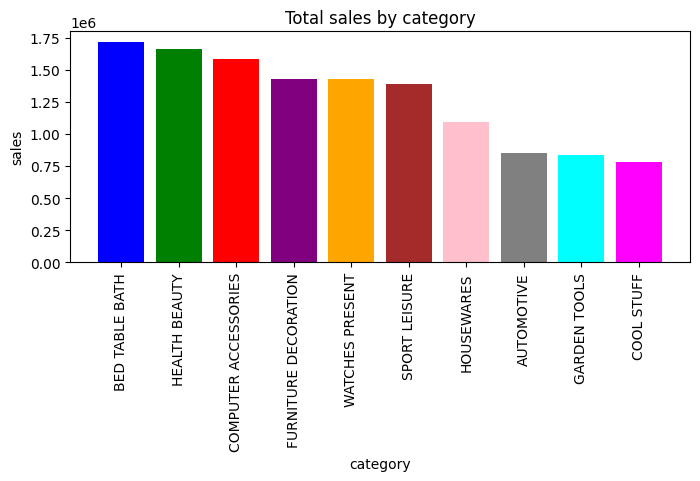

In [4]:
query = """ select upper(products.product_category) category, 
            sum(payments.payment_value) sales 
            from products join order_items on products.product_id = order_items.product_id 
            join payments on payments.order_id = order_items.order_id 
            group by category 
            order by 2 desc 
            limit 10 """
df = pd.read_sql(query, engine)
df.head()
data = [[1,2]]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
dp = pd.DataFrame(data, columns = ["category", "sales"])
dp = dp.sort_values(by = "sales", ascending = False)
plt.figure(figsize = (8,3))
plt.bar(df["category"], df["sales"], color = colors)
plt.xticks(rotation = 90)
plt.xlabel("category")
plt.ylabel("sales")
plt.title("Total sales by category")
plt.show(5)

## 4. Calculate the percentage of orders that were paid in installments.

In [5]:
query = """ SELECT 
   (SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END)::numeric / COUNT(*)::numeric) * 100 AS percentage_installments
FROM 
    payments; """
df = pd.read_sql(query, engine)
data = df.head().to_numpy()
print("The percentage of orders that were paid in installments is ", data[0][0])

The percentage of orders that were paid in installments is  99.99807481277554


## 5. Count the number of customers from each state.

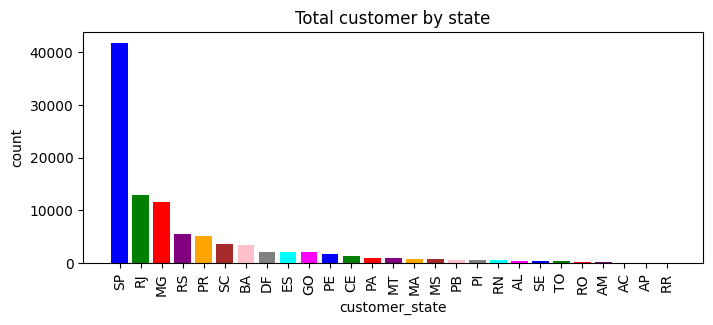

In [6]:
query = """ SELECT customer_state, count(customer_id) from customers
            GROUP BY 1
            ORDER BY 2 DESC
            """
df = pd.read_sql(query, engine)
df.head()
data = [[1,2]]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
dp = pd.DataFrame(data, columns = ["customer_state", "count"])
dp = dp.sort_values(by = "count", ascending = False)
plt.figure(figsize = (8,3))
plt.bar(df["customer_state"], df["count"], color = colors)
plt.xticks(rotation = 90)
plt.xlabel("customer_state")
plt.ylabel("count")
plt.title("Total customer by state")
plt.show()

## 6. Calculate the number of orders per month in 2018.

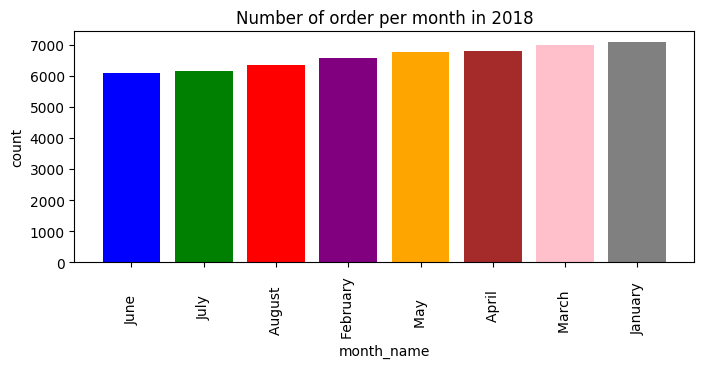

In [7]:
query = """ select TO_CHAR(CAST(order_purchase_timestamp AS TIMESTAMP), 'Month') AS month_name, 
            count(order_id) from orders
            where extract(year from cast(order_purchase_timestamp as timestamp)) = 2018
            group by 1
            order by 2
            """
df = pd.read_sql(query, engine)
df.head(8)
data = [[1,2]]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
o = ["January", "February","March","April","May","June","July","August","September","October"]
dp = pd.DataFrame(data, columns = ["month_name", "count"])
dp = dp.sort_values(by = "count", ascending = False)
plt.figure(figsize = (8,3))
plt.bar(df["month_name"], df["count"], color = colors)
plt.xticks(rotation = 90)
plt.xlabel("month_name")
plt.ylabel("count")
plt.title("Number of order per month in 2018")
plt.show()

## 7. Find the average number of products per order, grouped by customer city.

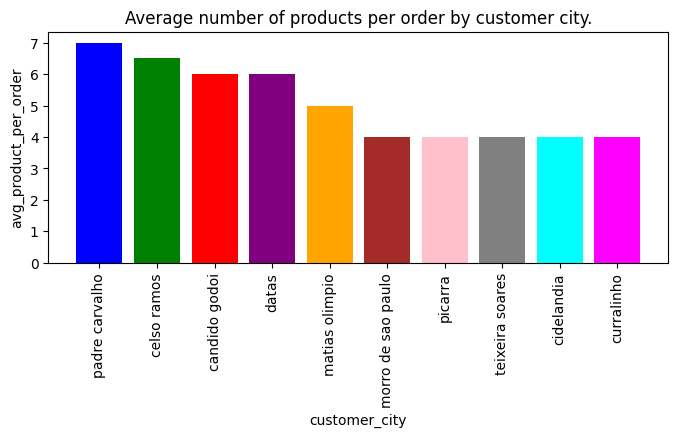

In [8]:
query = """ WITH temp AS (
	SELECT orders.order_id , orders.customer_id, count(order_items.order_id) AS OC
from orders join order_items
on orders.order_id = order_items.order_id
group by 1, 2
	)
	
SELECT customers.customer_city, round(avg(temp.OC), 2) as avg_product_per_order
from customers join temp
ON customers.customer_id = temp.customer_id
group by 1
order by 2 desc
LIMIT 10
            """
df = pd.read_sql(query, engine)
df.head(10)

data = [[1,2]]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
dp = pd.DataFrame(data, columns = ["customer_city", "avg_product_per_order"])
dp = dp.sort_values(by = "avg_product_per_order", ascending = False)
plt.figure(figsize = (8,3))
plt.bar(df["customer_city"], df["avg_product_per_order"], color = colors)
plt.xticks(rotation = 90)
plt.xlabel("customer_city")
plt.ylabel("avg_product_per_order")
plt.title("Average number of products per order by customer city.")
plt.show()

## 8. Calculate the percentage of total revenue contributed by each product category.

In [9]:
query = """ select upper(products.product_category) category, 
           round((sum(payments.payment_value)::numeric/(select sum(payment_value)::numeric from payments)) * 100,2) percentage_contribution 
            from products join order_items on products.product_id = order_items.product_id 
            join payments on payments.order_id = order_items.order_id 
            group by category 
            order by 2 desc 
            """
df = pd.read_sql(query, engine)
df.head(10)

,category,percentage_contribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


## 9. Identify the correlation between product price and the number of times a product has been purchased.

In [10]:
import numpy as np
query = """ select products.product_category, 
            count(order_items.product_id) as order_count,
            round(avg(order_items.price :: numeric),2) as price
            from products join order_items
            on products.product_id = order_items.product_id
            group by products.product_category

            """
df = pd.read_sql(query, engine)
df.head()

arr1 = df["order_count"]
arr2 = df["price"]
a = np.corrcoef([arr1,arr2])
print("The correlation is", a[0][-1], "so the number of orders has no impact on price")

The correlation is -0.10628724029296419 so the number of orders has no impact on price


## 10. Calculate the total revenue generated by each seller, and rank them by revenue.

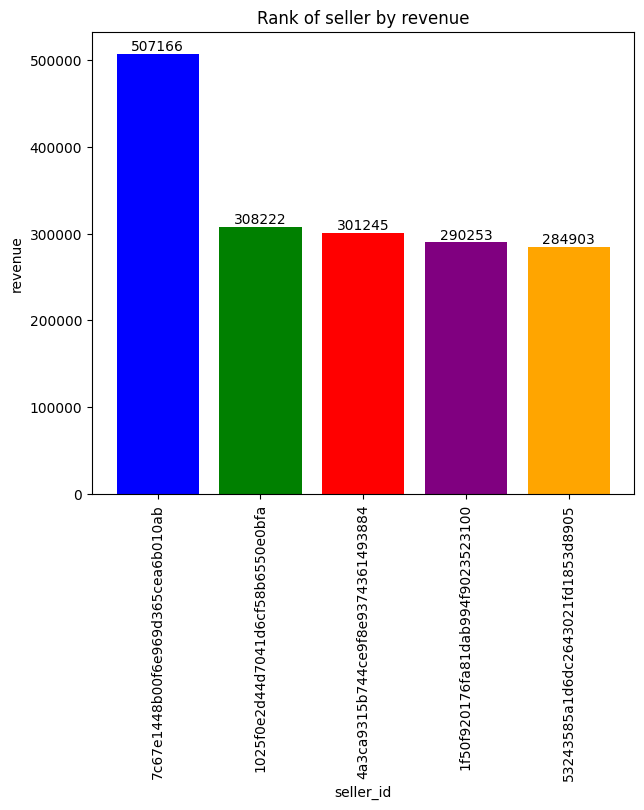

In [11]:
query = """ 
            with temp as (
        	select order_items.seller_id, 
        	sum(payments.payment_value::numeric)
        	as revenue
            from order_items
            JOIN payments ON order_items.order_id = payments.order_id
            group by 1 )

            select *, dense_rank() over(order by revenue desc) AS rank from temp
            LIMIT 5
            """
df = pd.read_sql(query, engine)
df.head()

data = [[1,2]]
colors = ['blue', 'green', 'red', 'purple', 'orange']
dp = pd.DataFrame(data, columns = ["seller_id", "revenue"])
dp = dp.sort_values(by = "revenue", ascending = False)
plt.figure(figsize = (7,6))
bars = plt.bar(df["seller_id"], df["revenue"], color = colors)
plt.xticks(rotation = 90)
plt.xlabel("seller_id")
plt.ylabel("revenue")
plt.title("Rank of seller by revenue")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), ha='center', va='bottom')

plt.show()

## 11. Calculate the moving average of order values for each customer over their order history.

In [12]:
query = """ with temp as (
                	select orders.customer_id, orders.order_purchase_timestamp, 
                    payments.payment_value as payment
                    from payments join orders
                    on payments.order_id = orders.order_id
                        )
select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from temp
            
            """
df = pd.read_sql(query, engine)
df.head(100)

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
95,003eab528664e1bd677218ef4be086ac,2017-04-03 19:20:39,77.10,77.10
96,003ec17a1389fa302f3a0423dddd8650,2018-01-14 17:25:31,17.77,17.77
97,003f7d92ac63c512bb6584219806f8df,2018-02-14 12:45:19,84.91,84.91
98,0040a8417928d0d5abd5169cd7877181,2018-06-27 17:38:07,219.49,219.49


## 12. Calculate the cumulative sales per month for each year.

In [13]:
query = """ with temp as (
			select 
			extract(year from cast(order_purchase_timestamp as timestamp)) as years,
			extract(month from cast(orders.order_purchase_timestamp as timestamp)) as months,
			round(sum(payments.payment_value::numeric),2) as payment from orders join payments
			on orders.order_id = payments.order_id
			group by 1, 2 order by 1, 2
                        )
    select years, months , payment as sales, sum(payment)
    over(order by years, months) cumulative_sales from temp
            
            """
df = pd.read_sql(query, engine)
df.head(22)

,years,months,sales,cumulative_sales
0,2016.0,10.0,47271.20,47271.20
1,2016.0,12.0,19.62,47290.82
2,2017.0,1.0,127430.74,174721.56
3,2017.0,2.0,269458.98,444180.54
4,2017.0,3.0,414369.39,858549.93
5,2017.0,4.0,390952.18,1249502.11
6,2017.0,5.0,566872.73,1816374.84
7,2017.0,6.0,490225.60,2306600.44
8,2017.0,7.0,566403.93,2873004.37
9,2017.0,8.0,646000.61,3519004.98


## 13. Calculate the year-over-year growth rate of total sales.

In [14]:
query = """ with temp as (
			select 
			extract(year from cast(order_purchase_timestamp as timestamp)) as years,
			round(sum(payments.payment_value::numeric),2) as payment from orders join payments
			on orders.order_id = payments.order_id
			group by 1 order by 1
                        )

        select years, round(((payment - lag(payment, 1) over(order by years))/
        lag(payment, 1) over(order by years)) * 100::numeric,2) as yoy_percentage_growth from temp
            
            """
df = pd.read_sql(query, engine)
df.head()

,years,yoy_percentage_growth
0,2016.0,NaN
1,2017.0,14533.76
2,2018.0,22.13


## 14. Identify the top 3 customers who spent the most money in each year.

<function matplotlib.pyplot.show(close=None, block=None)>

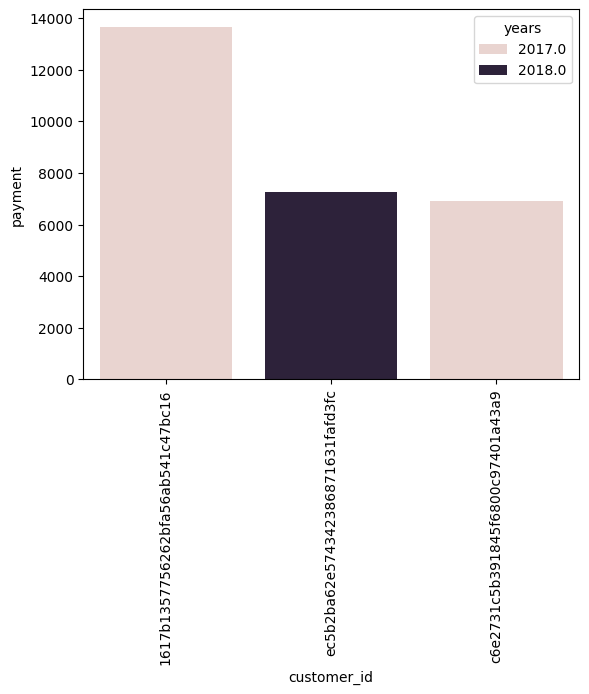

In [15]:
query = """ select years, customer_id, payment, rank
            from
                (select extract(year from cast(orders.order_purchase_timestamp as timestamp)) as years,
                orders.customer_id,
                sum(payments.payment_value) payment,
                dense_rank() over(partition by 1
                order by sum(payments.payment_value) desc) rank
                from orders join payments 
                on payments.order_id = orders.order_id
                group by 1,2) as a
                where rank <= 3
              """
df = pd.read_sql(query, engine)
data = df.head()
data
dn = pd.DataFrame(data, columns = ["years","customer_id","payment","rank"])
sns.barplot(x = "customer_id", y = "payment", data = dn, hue = "years")
plt.xticks(rotation = 90)
plt.show